In [1]:
# Imports
from typing_extensions import TypedDict
from typing import Literal, Optional
from langgraph.graph import START, END, StateGraph
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field

In [2]:
# Configuration
BASE_URL = "http://localhost:11434"
MODEL_NAME = "gemma3"

# Defining the LLM
def ollama_llm():
    return ChatOllama(
        model=MODEL_NAME,
        base_url=BASE_URL,
    )
llm = ollama_llm()

In [3]:
# State for analysing the state
class SentimentAnalysis(BaseModel):
    sentiment: Literal["Positive", "Negative"] = Field(description="The sentiment classification either Positive or Negative")
    confidence: float = Field(ge=0, le=1.0, description="Confidence score from 0.0 to 1.0")
    reason: str = Field(description="Brief Explanation")

In [4]:
# State for the Tweet
class SentimentState(TypedDict):
    original_tweet: str
    sentiment: str
    confidence: float

    response_tweet: str

In [5]:
# Nodes
def analyze_sentiment(state: SentimentState):
    tweet = state['original_tweet']
    print(f"Analyzing the tweet: {tweet}")

    sentiment_llm = llm.with_structured_output(SentimentAnalysis)

    messages = [
        SystemMessage(content="Analyze the sentiment in the tweet and provide the structured output. Use 0 to 1.0 for confidence, The negative the tweet, the closer it is to 0.0; The positive the tweet the closer it is to 1.0"),
        HumanMessage(content=tweet)
    ]

    analysis = sentiment_llm.invoke(messages)

    print(f"Analyzed Tweet: {analysis}")

    return {"sentiment": analysis.sentiment, "confidence": analysis.confidence}

In [6]:
state = {"original_tweet": "Just Released my new product, super excited! I hope it works guys!"}
analyze_sentiment(state)

Analyzing the tweet: Just Released my new product, super excited! I hope it works guys!
Analyzed Tweet: sentiment='Positive' confidence=0.85 reason="The tweet expresses excitement and hope, using positive language ('super excited', 'hope it works'). The exclamation mark further amplifies the positive sentiment."


{'sentiment': 'Positive', 'confidence': 0.85}

In [7]:
def positive_tweet(state: SentimentState):
    print(f"Current state in the positive node: {state}")
    messages = [
        SystemMessage(content=f"""Generate a warm response to this positive tweet under 280 chars.
                      Confidence: {state['confidence']}. High confidence means be enthusiastic otherwise be friendly.."""),
        HumanMessage(content=state['original_tweet'])
    ]
    response = llm.invoke(messages)
    return {"response_tweet": response.content.strip()}

In [8]:
def negative_tweet(state: SentimentState):
    print(f"The Negative tweet response node: {state}")
    messages = [
        SystemMessage(content=f"""Generate and empathetic response to this negative tweet under 280 chars.
                      If Confidence {state['confidence']} is very low then be empathetic otherwise 
                      be understanding."""),
        HumanMessage(content=state['original_tweet'])
    ]
    response = llm.invoke(messages)
    return {"response_tweet": response.content.strip()}

In [9]:
def route_by_sentiment(state: SentimentState):
    if state['sentiment'] == "positive":
        return "positive_response"
    else:
        return "negative_response"

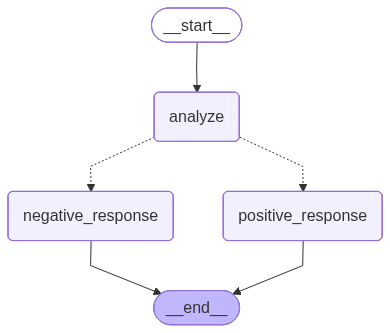

In [10]:
builder = StateGraph(SentimentState)

builder.add_node("analyze", analyze_sentiment)
builder.add_node("positive_response", positive_tweet)
builder.add_node("negative_response", negative_tweet)

builder.add_edge(START, "analyze")
builder.add_conditional_edges("analyze",
                              route_by_sentiment,
                              [
                                  "positive_response",
                                  "negative_response"
                              ])
builder.add_edge("positive_response", END)
builder.add_edge("negative_response", END)

graph = builder.compile()
graph

In [11]:
result = graph.invoke({'original_tweet': "Just launched my new product! the response from everyone has been amazing so far."})
result

Analyzing the tweet: Just launched my new product! the response from everyone has been amazing so far.
Analyzed Tweet: sentiment='Positive' confidence=0.95 reason="The tweet explicitly states a 'positive response' and uses enthusiastic language ('amazing')."
The Negative tweet response node: {'original_tweet': 'Just launched my new product! the response from everyone has been amazing so far.', 'sentiment': 'Positive', 'confidence': 0.95}


{'original_tweet': 'Just launched my new product! the response from everyone has been amazing so far.',
 'sentiment': 'Positive',
 'confidence': 0.95,
 'response_tweet': 'Okay, here are a few empathetic responses, tailored to different confidence levels:\n\n**If Confidence 0.95 (Very Positive Response):**\n\n“That’s absolutely fantastic! 🎉 Hearing such amazing feedback is so rewarding – you deserve to celebrate this huge achievement! Keep shining!”\n\n**If Confidence 0.50 (More Cautious/Unsure):**\n\n“That’s wonderful to hear *some* positive feedback! It can be tough putting yourself out there, and it’s great you’re getting a response.  Don’t be too hard on yourself – keep sharing your passion!”\n\n---\n\n**To help me tailor the response even better, could you tell me:**\n\n*   **What kind of product is it?** (e.g., software, handmade goods, service)\n*   **What’s the overall tone you’re going for?** (e.g., enthusiastic, supportive, gentle)'}

In [12]:
print(result["response_tweet"])

Okay, here are a few empathetic responses, tailored to different confidence levels:

**If Confidence 0.95 (Very Positive Response):**

“That’s absolutely fantastic! 🎉 Hearing such amazing feedback is so rewarding – you deserve to celebrate this huge achievement! Keep shining!”

**If Confidence 0.50 (More Cautious/Unsure):**

“That’s wonderful to hear *some* positive feedback! It can be tough putting yourself out there, and it’s great you’re getting a response.  Don’t be too hard on yourself – keep sharing your passion!”

---

**To help me tailor the response even better, could you tell me:**

*   **What kind of product is it?** (e.g., software, handmade goods, service)
*   **What’s the overall tone you’re going for?** (e.g., enthusiastic, supportive, gentle)


In [13]:
tweet = "I'm shattered, the company I started Failed terribly, I feel I'm worthless"
result = graph.invoke({"original_tweet": tweet})
result

Analyzing the tweet: I'm shattered, the company I started Failed terribly, I feel I'm worthless
Analyzed Tweet: sentiment='Negative' confidence=0.95 reason="The tweet expresses intense negative emotions - 'shattered,' 'failed terribly,' and 'worthless.' These words clearly indicate a state of distress and self-doubt."
The Negative tweet response node: {'original_tweet': "I'm shattered, the company I started Failed terribly, I feel I'm worthless", 'sentiment': 'Negative', 'confidence': 0.95}


{'original_tweet': "I'm shattered, the company I started Failed terribly, I feel I'm worthless",
 'sentiment': 'Negative',
 'confidence': 0.95,
 'response_tweet': "Okay, wow – that sounds absolutely devastating. It’s completely understandable to feel worthless after a business failure, especially after putting so much of yourself into it. Please know that this doesn't define your value. You’re allowed to grieve and feel this way. ❤️ Take things one step at a time. \n\n**(Confidence: 0.95 - Empathetic Response)**"}